# Capstone Project - The Battle of Neighborhoods:
## **Title: Crop Production Data Analysis and Trends Visualization of India**

![image.png](crop_front.jpg)

### **Question 1:** 
   Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.
   
### **Answer 1:** 
   **To provide the necessary information visualization to companies or different crop processing factories, I'll analyse the crop production datas of india in different region with Foursquare API.**


.

### **Question 2:**
   Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.
   
### **Answer 2:**
   **For this project I will use Kaggle crop production dataset(https://www.kaggle.com/divyosmi2009/crop-production-in-india-statevise?select=crop_production.csv) which contains more than 2,00,000 data rows with the detailed information of crop production in India with respect to defferent region and year.**
   
| Year |%Data|
| ---- |----:|
| 1997 | Min |
| 2002 | 25% |
| 2006 | 50% |
| 2010 | 75% |
| 2015 | Max |




***
## **A. Data Preparation**

### 1. Import all the necessory module and libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

#!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup


import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c anaconda seaborn --yes
import seaborn as sns; sns.set(color_codes=True)

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import branca.colormap as cl

In [2]:
#importing Ipython libraries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### 2. Reading Raw data from downloaded csv file:
   https://www.kaggle.com/divyosmi2009/crop-production-in-india-statevise?select=crop_production.csv
   <br>loading full dataset using pandas from the above file.</br>

In [3]:
df = pd.read_csv('crop_production.csv')
sh = df.shape
print('This DataFrame Contains {} rows and {} columns.'.format(sh[0], sh[1]))
df.head()

This DataFrame Contains 246091 rows and 7 columns.


State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0

### 3. Choose the crops for analysing:
    Only Crops that are available in the dataset are listed below. Choose upto 5 crops. You can see your choices in the next cell.
   (**Recomend to select one crop at a time.**)

In [4]:
opt_crop = sorted([i for i in set(df['Crop'])]) #list the crops that are available in the dataset
print('Please select as few as possible(Maximum 5) to get faster and perfect view!')
x = widgets.SelectMultiple(
    options=opt_crop,
    value=['Rice'],
    rows=10,
    description='Select Crop: ',
    disabled=False,
)
display(x)

Please select as few as possible(Maximum 5) to get faster and perfect view!


SelectMultiple(description='Select Crop: ', index=(95,), options=('Apple', 'Arcanut (Processed)', 'Arecanut', …

In [5]:
crops = x.value
print('Your Selections: ', ', '.join(map(str, crops)))

Your Selections:  Rice


### 4. Choose the Years for which data to be analysed:
    Only Years that are available in the dataset are listed below. Choose minimum 5. You can see your choices in the next cell. You can leave with default, It will select 2006 to 2015 autometically.
   (**Recomend to select 10 years at a time.**)

In [6]:
opt_year = [i for i in range(1997, 2016)]
print('Please select as few as possible to get faster view!')
y = widgets.SelectMultiple(
    options = opt_year,
    value=[i for i in range(2011,2016)],
    rows=10,
    description='Select Year: ',
    disabled=False,
)
display(y)

Please select as few as possible to get faster view!


SelectMultiple(description='Select Year: ', index=(14, 15, 16, 17, 18), options=(1997, 1998, 1999, 2000, 2001,…

In [7]:
years = y.value
print('Your Selections: ', ', '.join(map(str, years)))

Your Selections:  2011, 2012, 2013, 2014, 2015


### 5. Choose the Season to be analysed:
    Only Seasons that are available in the dataset are listed below. Choose any no of seasons. You can see your choices in the next cell. You can leave with default, It will select all the seasons autometically.
   (**Recomend to select all to get full data.**)

In [8]:
opt_ses = [i for i in set(df['Season'])]
print('Please select as few as possible to get faster view!')
z = widgets.SelectMultiple(
    options = opt_ses,
    value=['Summer     ', 'Winter     ', 'Whole Year ', 'Rabi       ', 'Autumn     ', 'Kharif     '],
    rows=6,
    description='Select Season: ',
    disabled=False,
)
display(z)

Please select as few as possible to get faster view!


SelectMultiple(description='Select Season: ', index=(0, 1, 2, 3, 4, 5), options=('Summer     ', 'Winter     ',…

In [9]:
seasons = z.value
print('Your Selections: ', ', '.join(map(str, [i.strip() for i in seasons])))

Your Selections:  Summer, Winter, Whole Year, Rabi, Autumn, Kharif


***
## **B. Prepare required dataframe for Analyzing data:**
### 1. create a new dataframe based on the previous selections.

In [10]:
df2 = pd.DataFrame(columns=['State_Name', 'District_Name', 'Latitude', 'Longitude']
                   +[i for i in years]
                   +[i for i in seasons]
                   +['Crop', 'Production'])
df2

Empty DataFrame
Columns: [State_Name, District_Name, Latitude, Longitude, 2011, 2012, 2013, 2014, 2015, Summer     , Winter     , Whole Year , Rabi       , Autumn     , Kharif     , Crop, Production]
Index: []

### 2. Define a function to retrive location data using geocoders:

In [11]:
#define function to retrive location data of a given dist, state.
def get_loc(dist, state):
    address = '{}, {}'.format(dist, state)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location is None: #check if the location is available for the given district and state
        locationd = geolocator.geocode(dist)
        locations = geolocator.geocode(state)
        if locationd is None: #check if the district location is available
            location = locations
        elif (abs(locations.latitude-locationd.latitude)>10) or (abs(locations.longitude-locationd.longitude)>10):
            location = locations
        else:
            location = locationd
    return location 


### 3. Insert datas into the newly created required Dataframe:

In [25]:
dist = df['District_Name'][0] #initialize with the very first district
state = df['State_Name'][0] #initialize with the very first state
location = get_loc(dist, state) #retrive and initialize the very first location
lat = location.latitude
long = location.longitude

for tup in list(zip(df['District_Name'], 
                    df['State_Name'], 
                    df['Crop_Year'], 
                    df['Season'], 
                    df['Crop'], 
                    df['Area'], 
                    df['Production'])):#zip the required column of the main dataframe
    
    if tup[0] != dist: #to avoid repetative fetching of location check when required
        dist = tup[0]
        state = tup[1]
        location = get_loc(dist, state)
        lat = location.latitude
        long = location.longitude
        
    if (tup[2] in years) and (tup[3] in seasons) and (tup[4] in crops): #take datas only for selected parameters
        df2 = df2.append({'State_Name': state, 
                          'District_Name': dist, 
                          'Latitude': lat, 
                          'Longitude': long, 
                          tup[2]: True, 
                          tup[3]: True, 
                          'Crop': tup[4], 
                          'Production': tup[6]}, ignore_index=True)

sh1 = df2.shape
print('This DataFrame is loaded with {} rows and {} columns.'.format(sh1[0], sh1[1]))
df2.head()

This DataFrame is loaded with 3345 rows and 17 columns.


State_Name District_Name   Latitude  Longitude  2011  2012  2013  2014  \
0  Andhra Pradesh     ANANTAPUR  14.654623   77.55626  True   NaN   NaN   NaN   
1  Andhra Pradesh     ANANTAPUR  14.654623   77.55626  True   NaN   NaN   NaN   
2  Andhra Pradesh     ANANTAPUR  14.654623   77.55626   NaN   1.0   NaN   NaN   
3  Andhra Pradesh     ANANTAPUR  14.654623   77.55626   NaN   1.0   NaN   NaN   
4  Andhra Pradesh     ANANTAPUR  14.654623   77.55626   NaN   NaN   1.0   NaN   

   2015  Summer       Winter       Whole Year   Rabi         Autumn       \
0   NaN          NaN          NaN          NaN          NaN          NaN   
1   NaN          NaN          NaN          NaN          1.0          NaN   
2   NaN          NaN          NaN          NaN          NaN          NaN   
3   NaN          NaN          NaN          NaN          1.0          NaN   
4   NaN          NaN          NaN          NaN          NaN          NaN   

  Kharif       Crop  Production  
0        True  Rice     94531.0  
1         NaN  Rice     25542.0  
2        True  Rice     58691.0  
3         NaN  Rice     17768.0  
4        True  Rice     59377.0

### 4. Calculate the required parameters using numpy:

In [13]:
mean = np.mean(df2['Production']) #get the mean Production amount
mini = int(np.min(df2['Production'])) #get the minimum Production amount
maxi = int(np.max(df2['Production'])) #get the maximum Production amount
print('Mean_Production=',mean, '\nMinimum_Production=',mini, '\nMaximum_Production=',maxi)
df2.describe() #get full description of the dataset

Mean_Production= 124351.31191374664 
Minimum_Production= 0 
Maximum_Production= 1624324


Latitude    Longitude   2012   2013   2014  2015  Summer       \
count  3345.000000  3345.000000  844.0  803.0  768.0  80.0        703.0   
mean     22.245682    82.789661    1.0    1.0    1.0   1.0          1.0   
std       5.688108     6.007560    0.0    0.0    0.0   0.0          0.0   
min       8.087964    70.464275    1.0    1.0    1.0   1.0          1.0   
25%      18.864065    77.556260    1.0    1.0    1.0   1.0          1.0   
50%      23.530745    82.296169    1.0    1.0    1.0   1.0          1.0   
75%      26.420727    86.820430    1.0    1.0    1.0   1.0          1.0   
max      34.611024    96.827000    1.0    1.0    1.0   1.0          1.0   

       Winter       Whole Year   Rabi         Autumn         Production  
count        570.0         26.0        178.0        507.0  3.339000e+03  
mean           1.0          1.0          1.0          1.0  1.243513e+05  
std            0.0          0.0          0.0          0.0  1.908388e+05  
min            1.0          1.0          1.0          1.0  0.000000e+00  
25%            1.0          1.0          1.0          1.0  5.813615e+03  
50%            1.0          1.0          1.0          1.0  3.930500e+04  
75%            1.0          1.0          1.0          1.0  1.650000e+05  
max            1.0          1.0          1.0          1.0  1.624324e+06

***
## **C. Analyse and map all the datapoints using Folium library:**
### 1. Get the location coordinates of India

In [14]:
address = 'India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of India are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of India are 22.3511148, 78.6677428.


### 2. Define a function to select the color for the different selected crops:

In [15]:
def color_selection(cr):
    try:
        if cr == crops[0]:
            return ['black', '#566573']
        
        if cr == crops[1]:
            return ['blue', '#5dade2']
                
        if cr == crops[2]:
            return ['green', '#82e0aa']
            
        if cr == crops[3]:
            return ['white', '#fdfefe']
        
        if cr == crops[4]:
            return ['yellow', '#f9e79f']            
    except:
        return ['red', '#f5b7b1']

### 3. Select the Circle radius multiplier:
    You can leave it default to keep maximum radious 40.

In [16]:
print('Select Circle Radius Multiplier')
mul = widgets.FloatSlider(value=40*mean/maxi,
                               min=0.5,
                               max=10.0,
                               step=0.5,
                               description='Select Multiplier:',
                               disabled=False,
                               continuous_update=False,
                               orientation='horizontal',
                               readout=True,
                               readout_format='.1f')
mul

Select Circle Radius Multiplier


FloatSlider(value=3.0622292575556758, continuous_update=False, description='Select Multiplier:', max=10.0, min…

In [17]:
multiplier=mul.value
multiplier

3.0622292575556758

### 4. Mark the locations in the India map as per the production quantity:
    After this step all the selected datas will be pointed on map. Hope you can easily visualize all the clusters. To avoid conflicts ignoring autometic clustering.

In [18]:
color_list = ['Black', 'Blue', 'Green', 'White', 'Yellow', 'Red']
print('''Color codes:
___________\n''') #Introduce the colors assigned for different crops
for i in range(len(crops)):
    try:
        print(crops[i],': ', color_list[i])
    except:
        print(crops[i],': ', color_list[5])
rad = 'Circle Radious: Min={a}, Max={b}'.format(b=maxi//int(mean)*multiplier, a=mini//int(mean)*multiplier)

for i in years:
    cap = '{} Production Data of {}. {}'.format(', '.join(map(str, crops)), i, rad)
    print('\n',cap)
    index = [mini, maxi*.10, maxi*.30, maxi*.60, maxi] #required for labeling
    
    map_india = folium.Map(location=[latitude, longitude], 
                           zoom_start=4, 
                           width = 500, 
                           height = 500, 
                           max_bounds=True) 
                           #tiles='Stamen Terrain') #create a map with fetched coordinates of India

    # add markers to map
    for lat, lng, state, dist, st, cr, pr in zip(df2['Latitude'], 
                                                 df2['Longitude'], 
                                                 df2['State_Name'], 
                                                 df2['District_Name'], 
                                                 df2[i], 
                                                 df2['Crop'], 
                                                 df2['Production']):
        
        if st == True:
            col = color_selection(cr)
            label = '{}({}), {}, {}'.format(cr, pr, dist, state) #label all the datapoints
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(location=[lat, lng], 
                                radius=(pr/mean*multiplier), 
                                popup=label, 
                                color=col[0], 
                                fill=True, 
                                fill_color=col[1], 
                                fill_opacity=0.5, 
                                parse_html=False).add_to(map_india) #mark the points on the map
            
    #specify the min and max values of your data YlOrRd_09
    colormap = cl.linear.Blues_09.scale(mini, maxi)
    colormap = colormap.to_step(index=index)
    colormap.caption = cap
    colormap.add_to(map_india) #add lagend to show caption and varition of data range.

    display(map_india)

Color codes:
___________

Rice :  Black

 Rice Production Data of 2011. Circle Radious: Min=0.0, Max=39.808980348223784



 Rice Production Data of 2012. Circle Radious: Min=0.0, Max=39.808980348223784



 Rice Production Data of 2013. Circle Radious: Min=0.0, Max=39.808980348223784



 Rice Production Data of 2014. Circle Radious: Min=0.0, Max=39.808980348223784



 Rice Production Data of 2015. Circle Radious: Min=0.0, Max=39.808980348223784


### **Sample Map**
![image.png](sample_map.png)

***
## **D. Observe the Yearly Production Trends(State Wise):**
   **Note: Ignore 2015 data as it seems to be incomplete**

### 1. Choose the State for which Production Trends to be visualize:
    Only states that are available in the dataset are listed below. Choose any no of states. You can see your choices in the next cell. You can leave with default, It will select the state with maximum production autometically.
   (**Recomend to select after observing map clusters properly.**)

In [19]:
opt_state = sorted([i for i in set(df['State_Name'])])
print('Please select as few as possible to get faster and perfect view!')
p = widgets.SelectMultiple(
    options=opt_state,
    value=[df2.loc[df2.index[df2['Production']==maxi].tolist()[0]].State_Name],
    rows=10,
    description='Select State: ',
    disabled=False,
)
display(p)

Please select as few as possible to get faster and perfect view!


SelectMultiple(description='Select State: ', index=(1,), options=('Andaman and Nicobar Islands', 'Andhra Prade…

In [20]:
states = p.value
print('Your Selections: ', ', '.join(map(str, states)))

Your Selections:  Andhra Pradesh


### 2. Choose the Crops for which Production Trends to be visualize:
    Only crops that are available in the dataset are listed below. Choose any no of crops. You can see your choices in the next cell. You can leave with default, It will select the previously selected crops autometically.
   (**Recomended to select one at a time.**)

In [21]:
opt_crops = sorted([i for i in set(df['Crop'])])
print('Please select as few as possible to get faster and perfect view!')
oc = widgets.SelectMultiple(
    options=opt_crops,
    value=[i for i in crops],
    rows=10,
    description='Select Crop: ',
    disabled=False,)
display(oc)

Please select as few as possible to get faster and perfect view!


SelectMultiple(description='Select Crop: ', index=(95,), options=('Apple', 'Arcanut (Processed)', 'Arecanut', …

In [22]:
opted_crops = oc.value
print('Your Selections: ', ', '.join(map(str, opted_crops)))

Your Selections:  Rice


### 3. Define functions for different plots with different libraries:

In [23]:
def plot_with_seaborn(df_var,x_var,y_var):
    try:
        plt.figure(figsize=(12, 4))
        sns.set(font_scale=1.5)
        sns.set_style('whitegrid')
        ax = sns.regplot(x=x_var, 
                         y=y_var, 
                         data=df_var, 
                         color='green', 
                         marker='+',  
                         scatter_kws={'s': 200})
        ax.set(xlabel=x_var, ylabel=y_var)
        ax.set_title('Trends of {} {} of {} from 1997 to 2014.'.format(j,y_var.split('_')[1],i))
        print('Trends of {} {} of {} from 1997 to 2014.'.format(j,y_var.split('_')[1],i))
    except:
        print('Unable to find Trends of {} {} of {} from 1997 to 2014.'.format(j,y_var.split('_')[1],i))
        pass
    
    
def bar_plot(df_var, x_var):
    df_var = df_var[['Crop_Year','Total_Production','Total_Area']]
    ax = df_var.plot(kind='bar',
                     figsize=(12, 4), 
                     width=0.8, 
                     color=['#5cb85c','#5bc0de'], 
                     title='Trends of {} Area vs. Production of {} from 1997 to 2014.'.format(j,i))
    ax.set_xticks(range(len(df_var)))
    ax.set_xlabel(x_var)
    ax.set_xticklabels([int(i) for i in df_var[x_var]]);
    
    
def scatter_plot_with_pyplot(df):
    plt.scatter(df_var[x_var], df_var[y_var])
    plt.show()

### 4. Final Step: Processed the data and extract required then plot to visualize:
    In this project I only show 4 plots for each selected crops. 
   * Crop_Year vs. Total_Production Trends with seaborn.
   * Crop_Year vs. Total_Area Trends with seaborn.
   * Crop_Year vs. Total_Production/Area Trends with seaborn.
   * Barplot of Production and Area with respect to Crop_Year.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Trends of Rice Production of Andhra Pradesh from 1997 to 2014.
Trends of Rice Area of Andhra Pradesh from 1997 to 2014.
Trends of Rice Production/Area of Andhra Pradesh from 1997 to 2014.


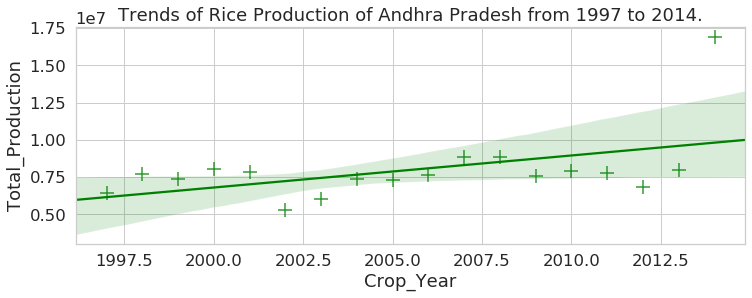

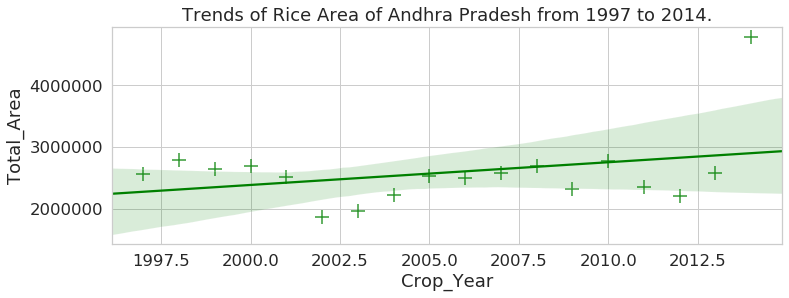

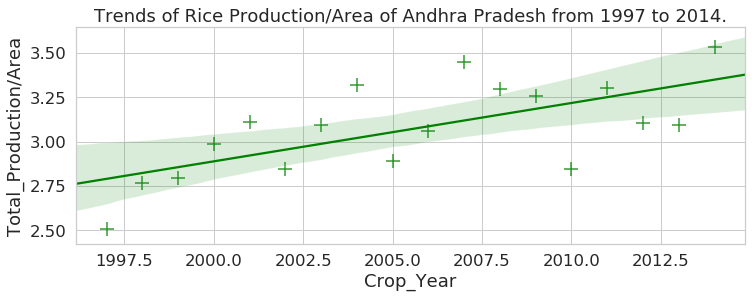

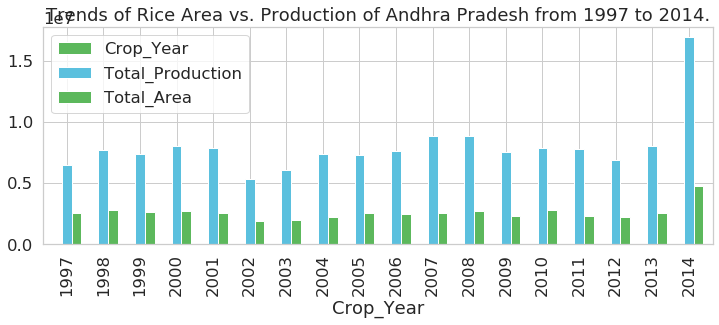

In [24]:
for i in states: #process for all selected states
    temp_df = None
    temp_df = df[df.State_Name==i]
    temp_df.drop(['Season'], axis = 1, inplace = True)
    for j in opted_crops: #process for all selected crops under each state
        new_df = temp_df[['Crop_Year','Production','Area']][temp_df.Crop==j]
        final_df = pd.DataFrame(columns=['Crop_Year','Total_Production','Total_Area','Total_Production/Area'])
        for k in range(1997,2015): #make temporarily required dataframe
            try:
                total_prod = sum(new_df['Production'][new_df.Crop_Year==k])
                total_area = sum(new_df['Area'][new_df.Crop_Year==k])
                prod_per_area = total_prod/total_area
            except:
                total_prod = 0
                total_area = 0
                Production_per_Area = 0
            final_df = final_df.append({'Crop_Year': k, 
                                        'Total_Production': total_prod, 
                                        'Total_Area': total_area, 
                                        'Total_Production/Area': prod_per_area}, ignore_index=True)
        #print(final_df)
        
        plot_with_seaborn(final_df, 'Crop_Year', 'Total_Production')
        plot_with_seaborn(final_df, 'Crop_Year', 'Total_Area')
        plot_with_seaborn(final_df, 'Crop_Year', 'Total_Production/Area')
        bar_plot(final_df, 'Crop_Year')
        #scatter_plot_with_pyplot(final_df)
    

***
# **~END~**